<a href="https://colab.research.google.com/github/Iceegan/BayesianAnomalyDetection/blob/master/RTLabAnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Setup

Make sure the data is placed in your 'My Drive' Directory

In [0]:
#run this cell in colab
%%capture
!pip install --upgrade pymc3

In [0]:
# Run this cell on colab
from google.colab import drive
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Imports needed to run the notebook. By default pymc3 needs to be udpated on Colab (top cell)

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import pymc3 as pm
import matplotlib.pyplot as plt
import os
import numpy as np

# Collect the data

This organizes the data into a set of dataframes. There are 4 events and we get voltage magnitude and generator frequency from each event to give a sample of the data available

In [0]:
# If your data is not directly copied into 'My Drive', change this line to point to the data
os.chdir('/content/drive/My Drive/ExtractedZoneN/Results/')

In [0]:
event1Bus = pd.read_csv('B7Grounding_abcFault/buses.csv', index_col='time')[['B7VA_Mag', 'B1VA_Mag']]
event2Bus = pd.read_csv('L59Grounding_abfault/buses.csv', index_col='time')[['B5VA_Mag', 'B8VA_Mag']]
event3Bus=pd.read_csv('L59LineOpen_abcFault/buses.csv', index_col='time')[['B5VA_Mag', 'B8VA_Mag']]
event4Bus=pd.read_csv('MachineLossM1_abc/buses.csv', index_col='time')[['B1VA_Mag', 'B9VA_Mag']]

event1Freq = pd.read_csv('B7Grounding_abcFault/freq.csv', index_col='time')[['SM1wm', 'SM10wm']]
event2Freq = pd.read_csv('B7Grounding_abcFault/freq.csv', index_col='time')[['SM1wm', 'SM10wm']]
event3Freq = pd.read_csv('B7Grounding_abcFault/freq.csv', index_col='time')[['SM1wm', 'SM10wm']]
event4Freq = pd.read_csv('B7Grounding_abcFault/freq.csv', index_col='time')[['SM1wm', 'SM10wm']]

event1 = pd.concat([event1Bus, event1Freq], axis=1)
event2 = pd.concat([event2Bus, event2Freq], axis=1)
event3 = pd.concat([event3Bus, event3Freq], axis=1)
event4 = pd.concat([event4Bus, event4Freq], axis=1)



Add noise and resample the data to Data. By default the simulated data is noiseless, which makes anomaly detection a trivial problem. Noise is added to more realistically simulate real data. 

The data here is resampled to reduce the computational time needed to run this notebook. For more accurate results, don't resample or decrease the resample factor.

Resampling changes the index from units of seconds to periods.

In [0]:
def addNoise(df, std=0.02):
  return df + np.random.normal(0, std, df.shape)

def resample(df, factor=50):
  # max_index = df.index[-1]
  # min_index = df.index[0]
  df = df.groupby(np.arange(len(df.index))//factor).mean()
  # df.index = df.index/df.index[-1]*max_index
  return df

event1 = resample(event1)
event1 = addNoise(event1)
event2 = resample(event2)
event2 = addNoise(event2)
event3 = resample(event3)
event3 = addNoise(event3)
event4 = resample(event4)
event4 = addNoise(event4)

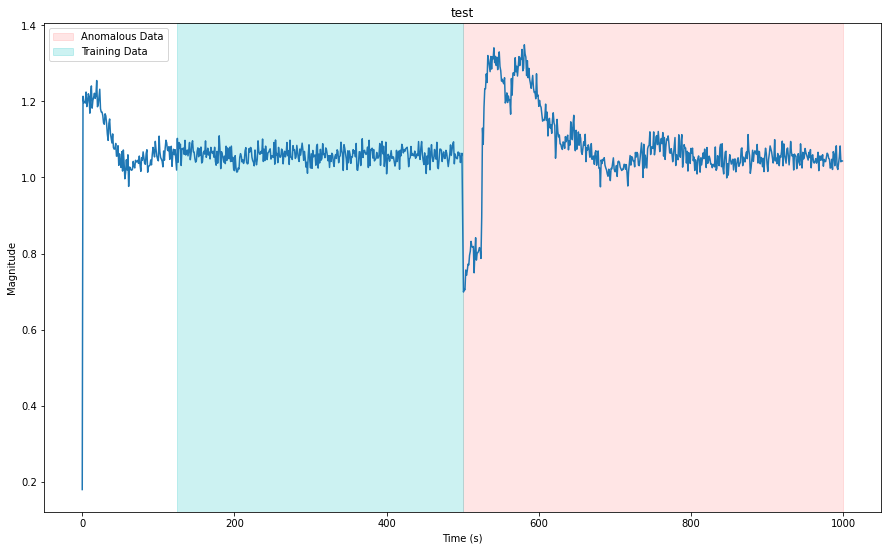

In [0]:
def prep_data(ser, title, train_start=2.5, train_stop=9, anom_end=1000):
  normal_data = ser[train_start:train_stop]
  # Get the first 2 seconds and last 5 seconds
  fig, ax = plt.subplots(1,1, figsize = (15,9))
  plt.title(title)
  plt.plot(ser.index, ser)
  ax.axvspan(train_stop, anom_end, alpha = 0.1, color = 'r', label = 'Anomalous Data')
  ax.axvspan(train_start, train_stop, alpha=0.2,color='c', label = 'Training Data')
  ax.set_xlabel('Time (s)')
  ax.set_ylabel('Magnitude')
  ax.legend()
  plt.show()

# Comment if you don't want to shorten the data set
prep_data(event1['B1VA_Mag'], 'test', train_start,anom_start)

# Create the AR model and sample it

In [0]:
"""
This function takes training data and returns the trace, a sampled posterior distribution.
normal_data: The steady state signal. Used as training data
reg_order: The order of the regression
"""
def getARTrace(normal_data, reg_order=10):
  AR_Model = pm.Model()
  with AR_Model:
      data = pm.Data('data', normal_data)
      rho=pm.Uniform('rho',-5,5,shape=reg_order)
      tau =pm.Gamma('tau',mu=1,sd=1)
      obs=pm.AR('observed',rho=rho,tau=tau,observed=data)
      trace=pm.sample(1000, tune=2000)
  return trace

Set the parameters for when to start the training data and where the anomaly starts. In general, `train_start` should be after the system reaches steady state, and anom_start should be right before the known time when the anomaly starts. These values are indeces of the data and not timestamps.

In [0]:
train_start = 125
anom_start = 501

Go through each eveent and get a trace for each signal. This takes a significant amount of time. After each event, the traces are serialized to a pickle file in case the runtime disconnects.

In [0]:
import pickle

event1Trace = {}
for column in event1.columns:
  normal_data = event1[column][train_start:anom_start]
  trace = getARTrace(normal_data)
  event1Trace[column] = trace

with open('event1traces.pickle', 'wb') as file:
            pickle.dump((event1Trace), file)

event2Trace = {}
for column in event2.columns:
  normal_data = event2[column][train_start:anom_start]
  trace = getARTrace(normal_data)
  event2Trace[column] = trace

with open('event2traces.pickle', 'wb') as file:
            pickle.dump((event2Trace), file)

event3Trace = {}
for column in event3.columns:
  normal_data = event3[column][train_start:anom_start]
  trace = getARTrace(normal_data)
  event3Trace[column] = trace

with open('event3traces.pickle', 'wb') as file:
            pickle.dump((event3Trace), file)

event4Trace = {}
for column in event4.columns:
  normal_data = event4[column][train_start:anom_start]
  trace = getARTrace(normal_data)
  event4Trace[column] = trace

with open('event4traces.pickle', 'wb') as file:
            pickle.dump((event4Trace), file)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [tau, rho]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [05:25<00:00,  9.23it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [tau, rho]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [06:00<00:00,  8.32it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [tau, rho]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [05:32<00:00,  9.02it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [tau, rho]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [05:42<00:00,  8.76it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [tau, 

Add the functions for predicting y(t) and graphing the prediction

In [0]:
"""
predict_AR function
trace: The trace that contains the AR parameters to use
horizon (int): how many time steps foward you would like to predict
y_initial (Series): the initial values for y to be used by the algorithm. Length of this is regression order
returns: a numpy array with one row per sample in the trace, one column per time value in horizon
"""

def predict_AR(trace, horizon, y_initial):
    rho = trace['rho'] # might need to reverse this
    order = len(y_initial)
    num_points = len(list(enumerate(trace.points())))
    y_t = np.zeros((num_points, horizon + order))
    y_t[:,0:order] = np.tile(y_initial,(num_points,1))
    for i in range(order,horizon+order):
        y_t[:,i] = np.sum(y_t[:,i-order:i]*rho,axis=1)
    return y_t[:,order-1:]

"""
get_percentile_df
turns a 5xN array of percentile values into a dataframe 
"""
def get_percentile_df(prediction):
    percentiles = np.percentile(prediction,[2.5,25,50,75,97.5],axis=0)
    # Put in a dataframe for easier access
    percentile_df = pd.DataFrame(
        {'5th Percentile': percentiles[0],
         '25th Percentile': percentiles[1],
         'Median': percentiles[2],
         '75th Percentile': percentiles[3],
         '95th Percentile': percentiles[4],
         'Mean': np.mean(prediction,axis=0)
        })
    return percentile_df

def plot_distribution_prediction(observed, percentile_df,ratio=1):
    fig,ax = plt.subplots(1,1,figsize=(15,9))
    ax.plot(observed.index*ratio,observed)
    ax.plot(percentile_df.index*ratio,percentile_df['Median'],alpha=0.75,color='k',label='Posterior median')
    ax.fill_between(percentile_df.index*ratio,percentile_df['5th Percentile'],percentile_df['95th Percentile'],alpha=0.5,color='c',label='Center 95%')
    ax.fill_between(percentile_df.index*ratio,percentile_df['25th Percentile'],percentile_df['75th Percentile'],alpha=0.2,color='b',label='Center 50%')
    ax.axvline(x=observed.index[-1]*ratio,linestyle='--',color='r', alpha=0.5, label = 'End of training data')
    ax.legend()
    ax.set_xlim(observed.index[0]*ratio,percentile_df.index[-1]*ratio)
    ax.set_xlabel('Time')
    ax.set_ylabel('Magnitude')
    ax.set_title('Prediction of Current Magnitude')
    return fig, ax

def find_anomaly_index(actual, percentile_df):
    for idx in percentile_df.index:
        obs = actual.loc[idx]
        p95 = percentile_df.loc[idx]['95th Percentile']
        p5 = percentile_df.loc[idx]['5th Percentile']

        if obs < p5 or obs > p95:
            return idx

    return None
            

# Predict for future time steps and graph it

This next section goes through each signal where a trace was found above. For each signal, it plots the trace, predicts ten time steps in advance, and determines if an anomaly occured in those ten time stamps.

In [0]:
"""
Plot actual and predicted data and determine if an anomaly occured.
trace: the trained trace. Can be found with getARTrace()
normal_data: the training series  used for the trace. The last time step of this 
    data is where the prediction will begin.
full_data: the known full time sereies. normal_data should be a subset of this series
anom_start: the index where the anomaly detection begins
title: Title for the output graph
ratio: If the data was resampled, this can be used to turn indexes back into time units.
  For example, if the data was resampled by a factor of 50, ratio = 1/50.
reg_order: the regression order used for the trace
step_horizon: how many time steps to predict. More time steps results in less 
  certainty in the prediction.
"""
def plotPrediction(trace, normal_data, full_data, anom_start, title, ratio=1, reg_order=10, step_horizon=10, ):
  # Show the Traceplot
  pm.traceplot(trace)
  plt.show()
  print(pm.summary(trace))

  #Get a prediction for the next step_horizon periods
  step_horizon = 10
  prediction = predict_AR(trace,step_horizon,normal_data.iloc[-reg_order:])
  # prediction = predict_AR(trace,step_horizon,normal_data.iloc[anom_start-reg_order:anom_start])
  # Get the percentiles for the prediction and reindex for graphing
  percentile_df = get_percentile_df(prediction)
  percentile_df.index = percentile_df.index + normal_data.index[-1]

  ratio = 1/50

  # Plot the predicted data
  fig, ax = plot_distribution_prediction(normal_data.iloc[-20:],percentile_df, ratio=ratio)

  # Plot the actual data not used in the training
  ax.plot(full_data.index[anom_start-1:anom_start+step_horizon]*ratio,
          full_data.iloc[anom_start-1:anom_start+step_horizon],
          label='Actual data',
          color = 'r')
  ax.set_title(title)
  # ax.set_ylim([-0.25,0.1])

  #Find and plot the location of the first detected anomaly
  anom_loc = find_anomaly_index(full_data,percentile_df)
  if anom_loc is not None:
      plt.axvline(x=anom_loc*ratio, label = 'Anomaly detected', linestyle = '--')
      print('Anomaly detected at iloc[{0}], or {1}s'.format(anom_loc, anom_loc/1000*20))
  else:
      print('No Anomalies detected')
  ax.legend()
  plt.show()

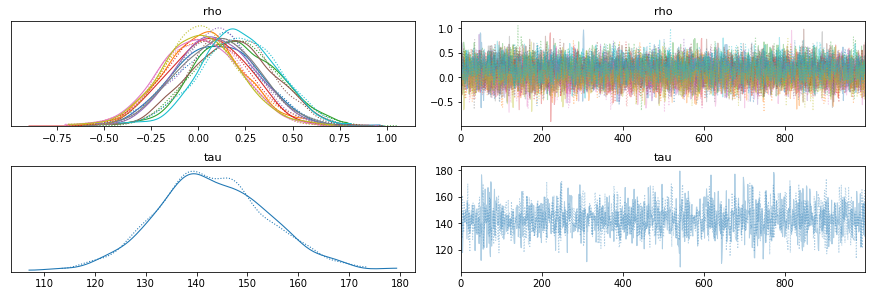

           mean      sd   hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
rho[0]    0.099   0.225   -0.297    0.543  ...   916.0    2074.0    1295.0    1.0
rho[1]    0.032   0.215   -0.364    0.451  ...   744.0    2031.0    1068.0    1.0
rho[2]    0.200   0.218   -0.186    0.615  ...  1293.0    1988.0    1343.0    1.0
rho[3]    0.051   0.212   -0.340    0.417  ...   930.0    2173.0    1426.0    1.0
rho[4]    0.093   0.204   -0.308    0.450  ...  1301.0    1845.0    1680.0    1.0
rho[5]    0.178   0.212   -0.208    0.574  ...  1331.0    2207.0    1530.0    1.0
rho[6]    0.011   0.212   -0.368    0.409  ...   926.0    1923.0    1368.0    1.0
rho[7]    0.100   0.212   -0.287    0.494  ...  1012.0    2108.0    1409.0    1.0
rho[8]    0.019   0.205   -0.344    0.410  ...   802.0    1795.0    1565.0    1.0
rho[9]    0.216   0.203   -0.157    0.587  ...  1454.0    2009.0    1453.0    1.0
tau     143.153  10.996  121.539  163.273  ...  1909.0    1940.0    1359.0    1.0

[11 rows x 11 c

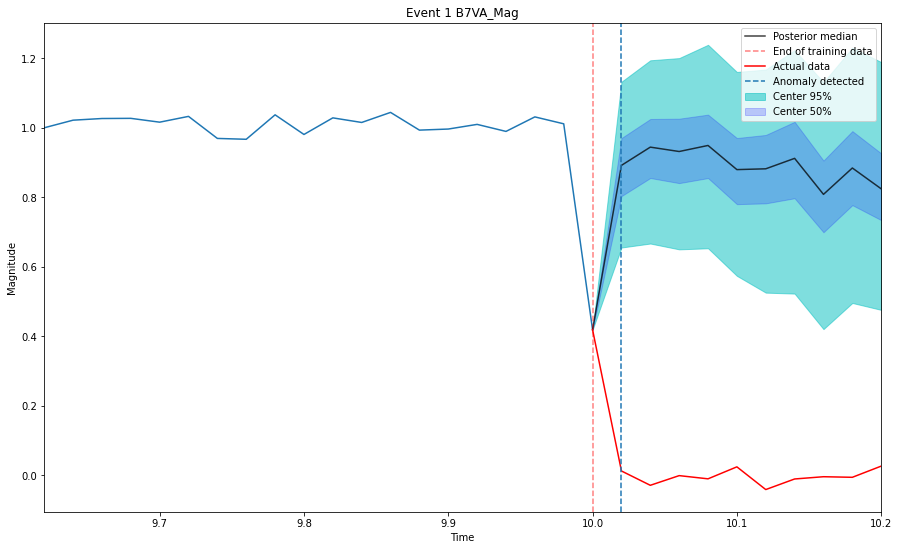

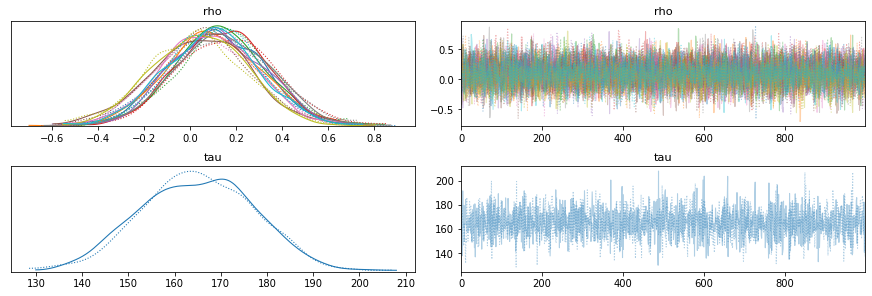

           mean      sd   hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
rho[0]    0.099   0.205   -0.283    0.478  ...   980.0    2193.0    1286.0    1.0
rho[1]    0.100   0.211   -0.295    0.501  ...  1097.0    2548.0    1422.0    1.0
rho[2]    0.137   0.202   -0.259    0.510  ...  1196.0    2979.0    1441.0    1.0
rho[3]    0.151   0.205   -0.229    0.529  ...   922.0    2805.0    1057.0    1.0
rho[4]    0.118   0.205   -0.233    0.516  ...  1300.0    2281.0    1436.0    1.0
rho[5]    0.048   0.214   -0.347    0.473  ...   822.0    2472.0    1329.0    1.0
rho[6]    0.073   0.206   -0.309    0.446  ...  1181.0    2804.0    1662.0    1.0
rho[7]    0.138   0.215   -0.268    0.530  ...  1239.0    3528.0    1483.0    1.0
rho[8]    0.035   0.208   -0.379    0.399  ...   951.0    2642.0    1482.0    1.0
rho[9]    0.100   0.198   -0.256    0.487  ...  1113.0    2260.0    1349.0    1.0
tau     165.107  12.297  143.270  187.964  ...  3491.0    3493.0    1642.0    1.0

[11 rows x 11 c

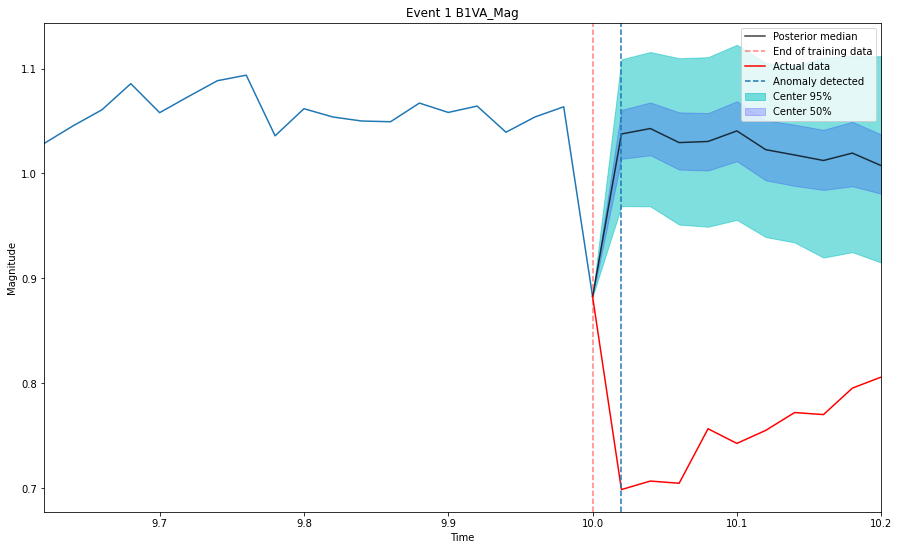

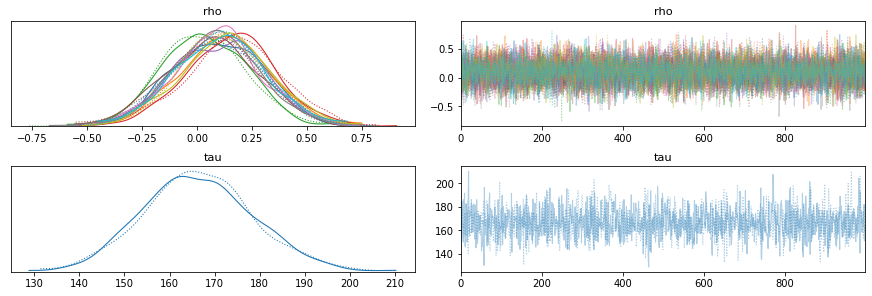

           mean      sd   hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
rho[0]    0.097   0.206   -0.271    0.484  ...  1002.0    2303.0    1279.0    1.0
rho[1]    0.124   0.204   -0.248    0.508  ...  1025.0    2398.0    1437.0    1.0
rho[2]    0.029   0.193   -0.306    0.404  ...  1011.0    2602.0    1717.0    1.0
rho[3]    0.165   0.203   -0.245    0.529  ...  1400.0    1895.0    1220.0    1.0
rho[4]    0.097   0.208   -0.271    0.506  ...  1066.0    2114.0    1447.0    1.0
rho[5]    0.070   0.212   -0.326    0.461  ...  1143.0    2443.0    1460.0    1.0
rho[6]    0.099   0.198   -0.295    0.454  ...  1180.0    2160.0    1471.0    1.0
rho[7]    0.084   0.199   -0.285    0.455  ...  1175.0    2403.0    1488.0    1.0
rho[8]    0.129   0.203   -0.250    0.509  ...  1250.0    2290.0    1425.0    1.0
rho[9]    0.105   0.200   -0.267    0.479  ...  1221.0    2172.0    1353.0    1.0
tau     166.485  12.186  144.326  190.038  ...  1848.0    1869.0    1337.0    1.0

[11 rows x 11 c

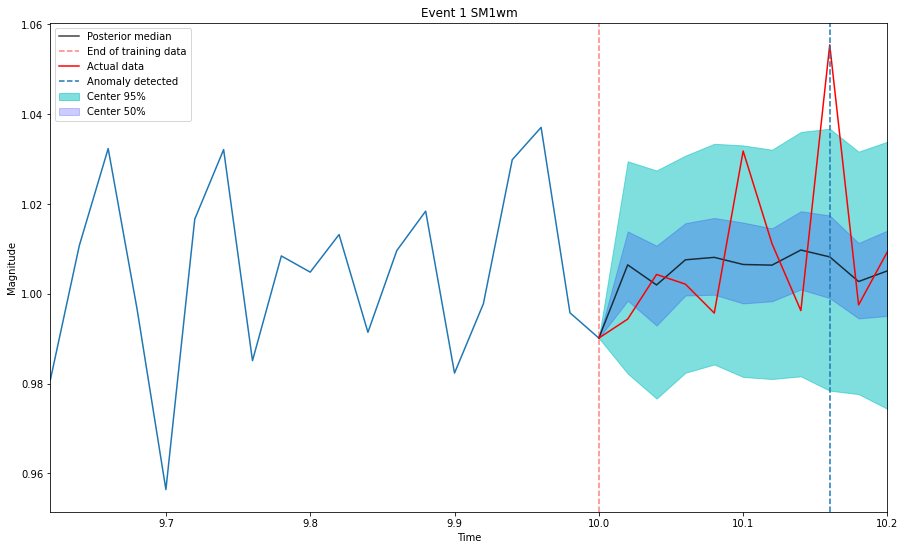

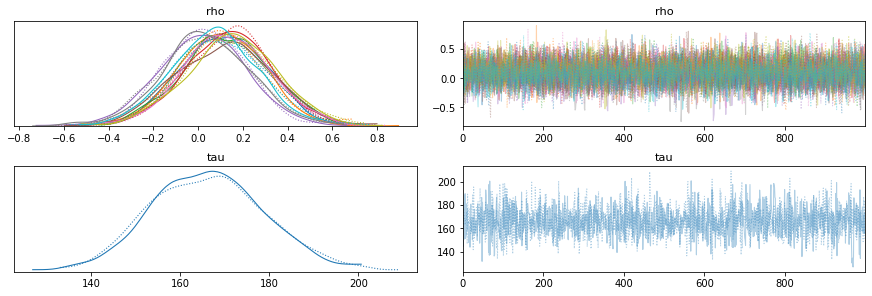

           mean      sd   hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
rho[0]    0.110   0.197   -0.246    0.462  ...  1287.0    2181.0    1405.0    1.0
rho[1]    0.098   0.196   -0.292    0.450  ...   910.0    1987.0    1123.0    1.0
rho[2]    0.125   0.196   -0.216    0.518  ...  1423.0    2576.0    1332.0    1.0
rho[3]    0.135   0.189   -0.231    0.477  ...  1594.0    2358.0    1486.0    1.0
rho[4]    0.025   0.190   -0.315    0.381  ...   936.0    2119.0    1208.0    1.0
rho[5]    0.120   0.210   -0.272    0.512  ...  1159.0    2168.0    1484.0    1.0
rho[6]    0.127   0.195   -0.262    0.474  ...  1087.0    2697.0    1310.0    1.0
rho[7]    0.035   0.200   -0.359    0.395  ...   948.0    2150.0    1343.0    1.0
rho[8]    0.150   0.204   -0.244    0.518  ...  1150.0    1748.0    1332.0    1.0
rho[9]    0.075   0.198   -0.307    0.428  ...  1082.0    2509.0    1595.0    1.0
tau     166.337  12.819  142.761  190.345  ...  2345.0    2390.0    1373.0    1.0

[11 rows x 11 c

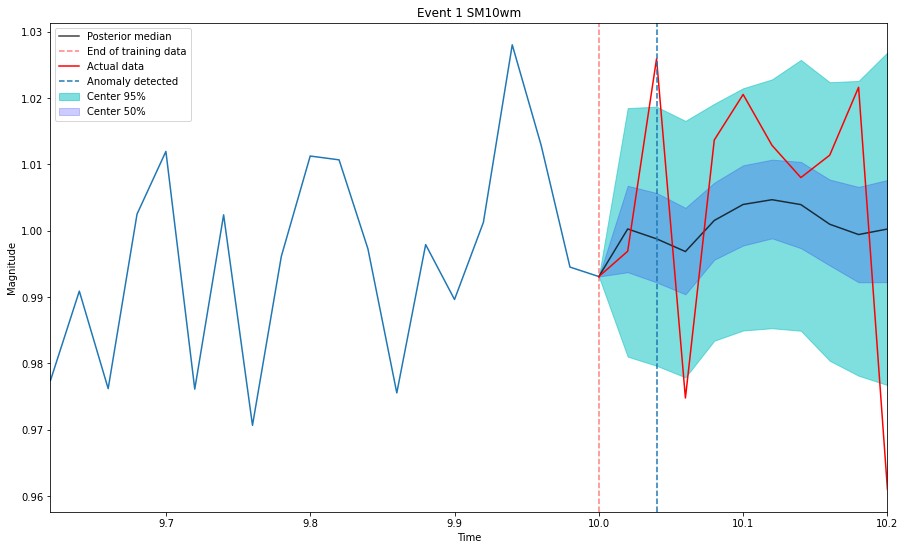

In [0]:
for column in event1.columns:
  trace = event1Trace[column]
  full_data = event1[column]
  normal_data = full_data[train_start:anom_start]
  ratio = 1/50
  plotPrediction(trace, normal_data, full_data, anom_start, 'Event 1 {}'.format(column), ratio=ratio)

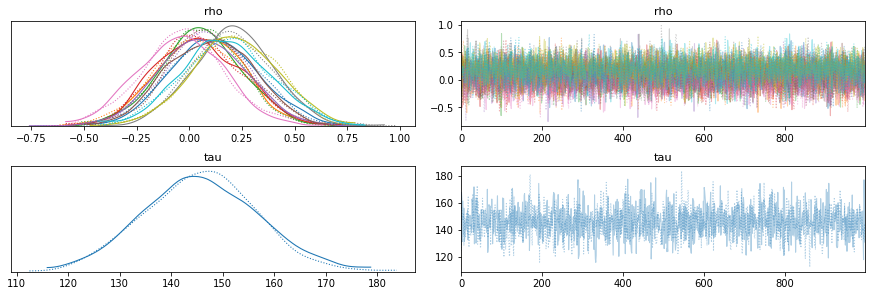

           mean      sd   hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
rho[0]    0.118   0.209   -0.256    0.518  ...  1310.0    2414.0    1431.0    1.0
rho[1]    0.047   0.205   -0.320    0.435  ...   892.0    2152.0    1246.0    1.0
rho[2]    0.055   0.190   -0.317    0.406  ...  1207.0    1937.0    1545.0    1.0
rho[3]    0.046   0.206   -0.317    0.435  ...   845.0    2582.0    1304.0    1.0
rho[4]    0.071   0.201   -0.291    0.441  ...  1051.0    2470.0    1394.0    1.0
rho[5]    0.096   0.198   -0.261    0.475  ...  1256.0    2485.0    1512.0    1.0
rho[6]   -0.033   0.201   -0.460    0.305  ...  1052.0    2426.0    1438.0    1.0
rho[7]    0.207   0.194   -0.164    0.559  ...  1602.0    2270.0    1434.0    1.0
rho[8]    0.214   0.201   -0.153    0.589  ...  1681.0    2244.0    1249.0    1.0
rho[9]    0.178   0.213   -0.200    0.597  ...  1531.0    2555.0    1547.0    1.0
tau     145.746  10.954  124.144  165.628  ...  2035.0    2023.0    1402.0    1.0

[11 rows x 11 c

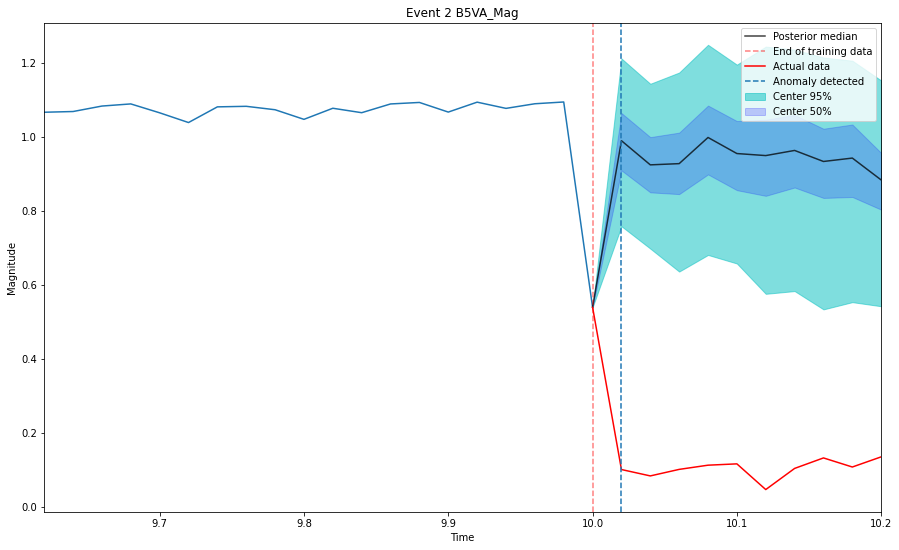

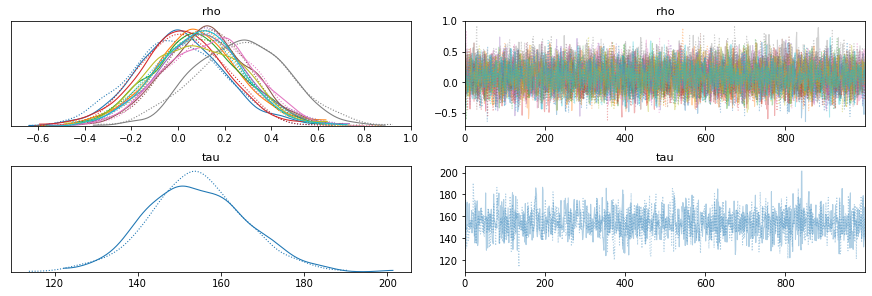

           mean      sd   hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
rho[0]    0.002   0.197   -0.368    0.373  ...   972.0    2148.0    1359.0    1.0
rho[1]    0.078   0.191   -0.290    0.448  ...   972.0    1708.0    1324.0    1.0
rho[2]    0.083   0.192   -0.282    0.431  ...  1209.0    1856.0    1631.0    1.0
rho[3]    0.023   0.185   -0.322    0.368  ...   890.0    2015.0    1411.0    1.0
rho[4]    0.105   0.192   -0.265    0.463  ...  1041.0    1699.0    1209.0    1.0
rho[5]    0.124   0.183   -0.245    0.451  ...  1282.0    1909.0    1194.0    1.0
rho[6]    0.135   0.190   -0.229    0.472  ...  1209.0    1882.0    1288.0    1.0
rho[7]    0.273   0.199   -0.092    0.644  ...  1739.0    2062.0    1298.0    1.0
rho[8]    0.087   0.196   -0.301    0.432  ...  1146.0    2143.0    1366.0    1.0
rho[9]    0.089   0.188   -0.272    0.426  ...  1164.0    1929.0    1479.0    1.0
tau     154.150  11.674  132.833  176.717  ...  1781.0    1803.0    1258.0    1.0

[11 rows x 11 c

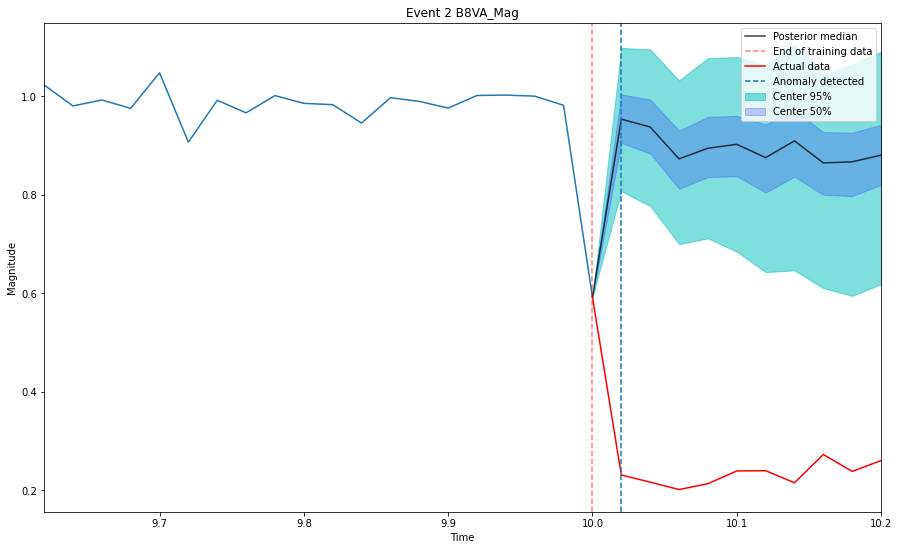

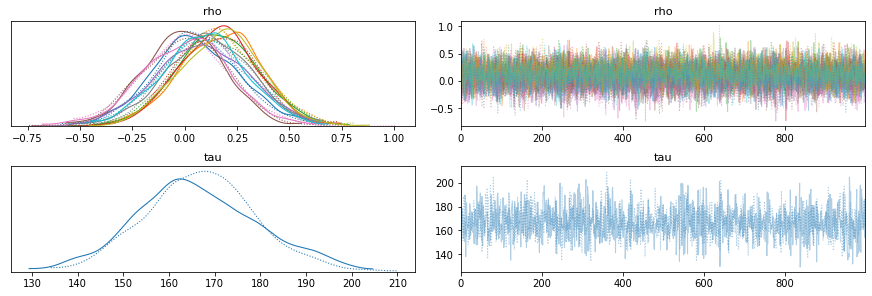

           mean      sd   hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
rho[0]    0.055   0.204   -0.336    0.439  ...   854.0    2788.0    1454.0   1.00
rho[1]    0.164   0.194   -0.186    0.551  ...  1466.0    2026.0    1188.0   1.00
rho[2]    0.154   0.201   -0.191    0.562  ...  1315.0    1821.0    1195.0   1.00
rho[3]    0.153   0.190   -0.200    0.495  ...  1307.0    2135.0    1484.0   1.00
rho[4]    0.087   0.213   -0.294    0.496  ...  1081.0    2381.0    1169.0   1.00
rho[5]    0.000   0.196   -0.370    0.346  ...   727.0    2407.0    1457.0   1.00
rho[6]    0.008   0.209   -0.418    0.373  ...   915.0    1996.0    1345.0   1.01
rho[7]    0.109   0.200   -0.261    0.482  ...  1176.0    2432.0    1319.0   1.00
rho[8]    0.173   0.197   -0.196    0.537  ...  1415.0    2084.0    1301.0   1.00
rho[9]    0.095   0.204   -0.306    0.453  ...  1131.0    2428.0    1377.0   1.00
tau     166.577  12.700  143.127  191.695  ...  1805.0    1883.0    1030.0   1.00

[11 rows x 11 c

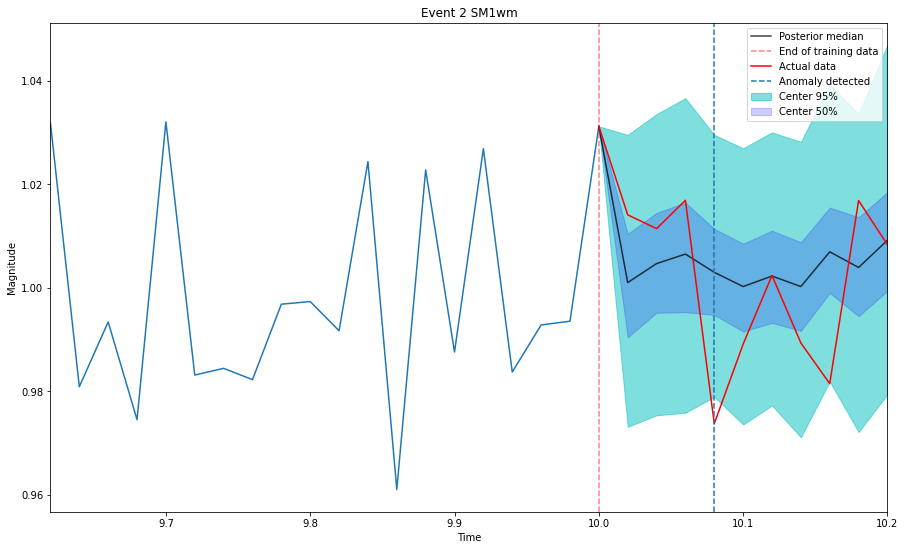

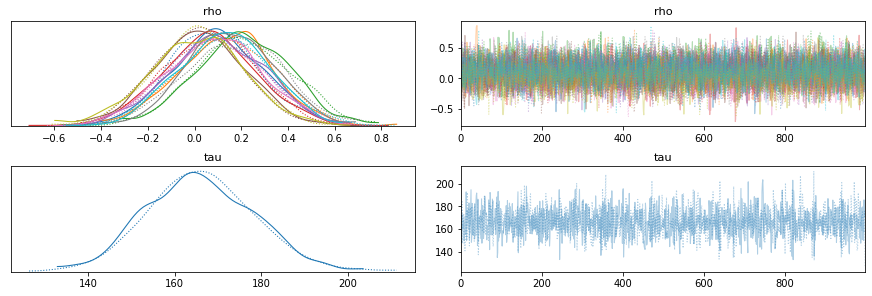

           mean      sd   hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
rho[0]    0.093   0.193   -0.237    0.492  ...  1064.0    2032.0    1284.0    1.0
rho[1]    0.137   0.200   -0.256    0.486  ...  1079.0    2294.0    1420.0    1.0
rho[2]    0.208   0.203   -0.175    0.575  ...  1299.0    1888.0    1133.0    1.0
rho[3]    0.066   0.203   -0.314    0.442  ...   824.0    2461.0    1244.0    1.0
rho[4]    0.090   0.206   -0.301    0.474  ...  1136.0    2338.0    1363.0    1.0
rho[5]    0.021   0.191   -0.319    0.386  ...  1033.0    1961.0    1375.0    1.0
rho[6]    0.086   0.210   -0.287    0.495  ...   910.0    2381.0    1185.0    1.0
rho[7]    0.160   0.199   -0.200    0.539  ...  1519.0    2094.0    1296.0    1.0
rho[8]    0.012   0.199   -0.375    0.376  ...   718.0    2182.0    1042.0    1.0
rho[9]    0.126   0.200   -0.242    0.490  ...  1155.0    2061.0    1324.0    1.0
tau     166.063  12.302  142.876  188.495  ...  2482.0    2518.0    1532.0    1.0

[11 rows x 11 c

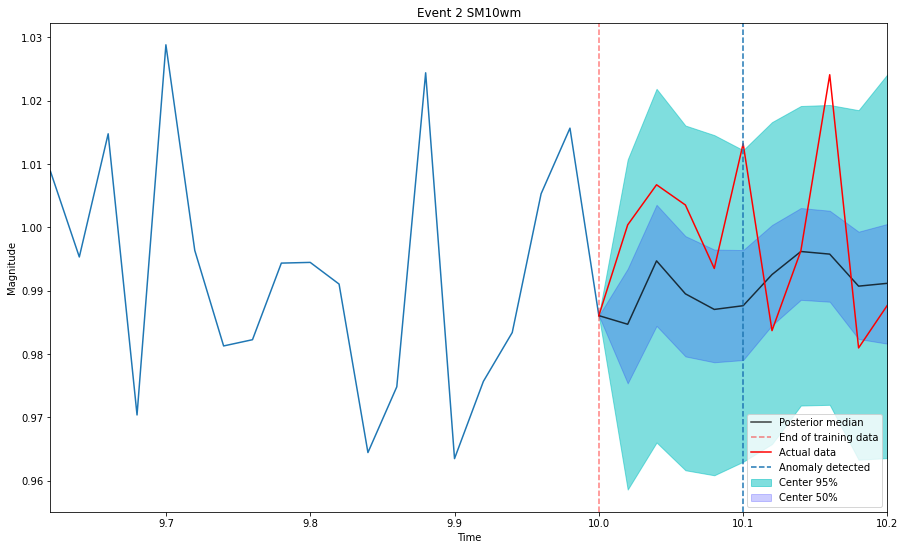

In [0]:
with open('event2traces.pickle', 'rb') as file:
        event2TracePickle = pickle.load(file)
for column in event2.columns:
  trace = event2TracePickle[column]
  full_data = event2[column]
  normal_data = full_data[train_start:anom_start]
  ratio = 1/50
  plotPrediction(trace, normal_data, full_data, anom_start, 'Event 2 {}'.format(column), ratio=ratio)

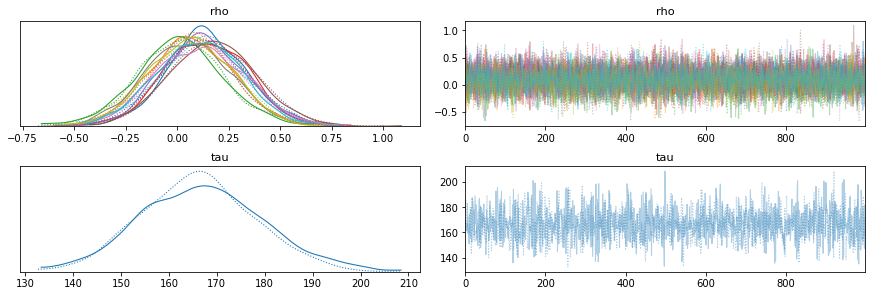

           mean      sd   hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
rho[0]    0.140   0.199   -0.235    0.530  ...  1436.0    2978.0    1356.0    1.0
rho[1]    0.067   0.197   -0.294    0.460  ...  1180.0    2679.0    1448.0    1.0
rho[2]    0.013   0.209   -0.361    0.439  ...   912.0    3269.0    1635.0    1.0
rho[3]    0.139   0.203   -0.250    0.498  ...  1210.0    2505.0    1366.0    1.0
rho[4]    0.123   0.203   -0.247    0.515  ...  1184.0    3028.0    1276.0    1.0
rho[5]    0.175   0.210   -0.189    0.584  ...   962.0    2498.0    1093.0    1.0
rho[6]    0.106   0.213   -0.267    0.521  ...   981.0    2423.0    1230.0    1.0
rho[7]    0.061   0.202   -0.324    0.446  ...  1068.0    2398.0    1193.0    1.0
rho[8]    0.063   0.205   -0.330    0.431  ...   794.0    2724.0    1225.0    1.0
rho[9]    0.111   0.206   -0.256    0.518  ...  1159.0    2851.0    1415.0    1.0
tau     166.604  12.228  145.959  192.298  ...  2333.0    2429.0    1423.0    1.0

[11 rows x 11 c

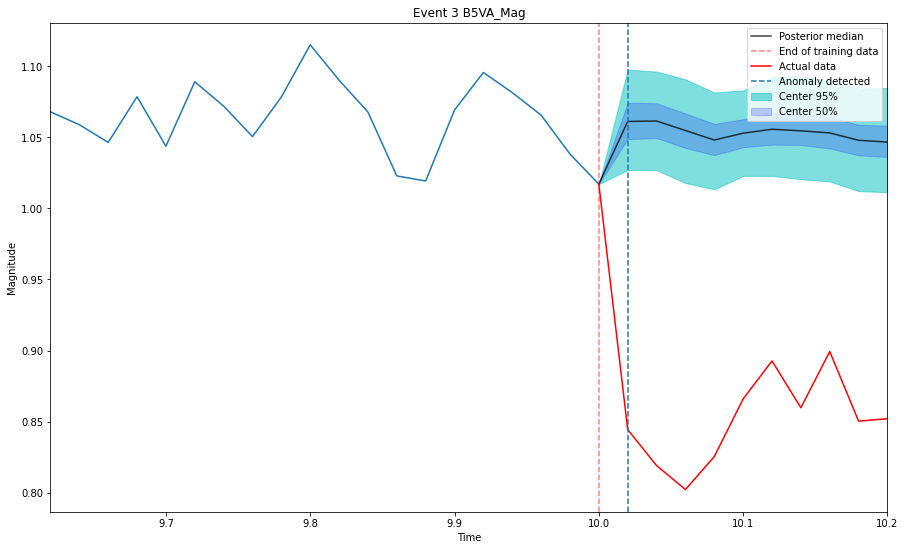

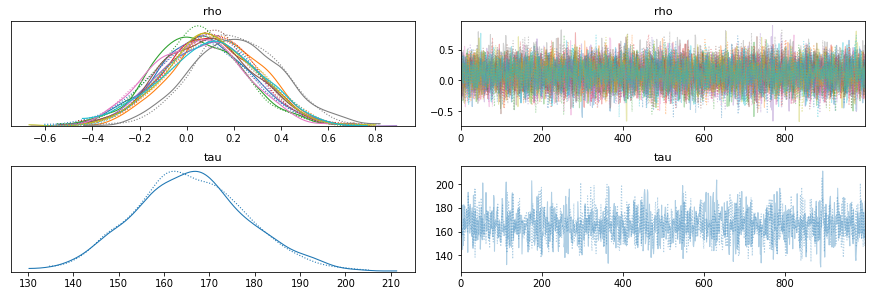

           mean      sd   hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
rho[0]    0.062   0.204   -0.341    0.429  ...  1032.0    2133.0    1228.0    1.0
rho[1]    0.124   0.191   -0.219    0.490  ...  1572.0    2488.0    1414.0    1.0
rho[2]    0.050   0.192   -0.314    0.429  ...   893.0    2158.0    1399.0    1.0
rho[3]    0.101   0.196   -0.264    0.471  ...  1109.0    1863.0    1318.0    1.0
rho[4]    0.094   0.198   -0.280    0.448  ...   995.0    2209.0    1370.0    1.0
rho[5]    0.093   0.191   -0.242    0.470  ...  1207.0    1906.0    1461.0    1.0
rho[6]    0.055   0.200   -0.318    0.412  ...  1099.0    2044.0    1502.0    1.0
rho[7]    0.211   0.193   -0.131    0.586  ...  1602.0    2548.0    1632.0    1.0
rho[8]    0.103   0.196   -0.273    0.443  ...  1001.0    1955.0    1237.0    1.0
rho[9]    0.107   0.203   -0.283    0.467  ...   962.0    2060.0    1190.0    1.0
tau     165.836  12.382  144.085  190.933  ...  2132.0    2167.0    1368.0    1.0

[11 rows x 11 c

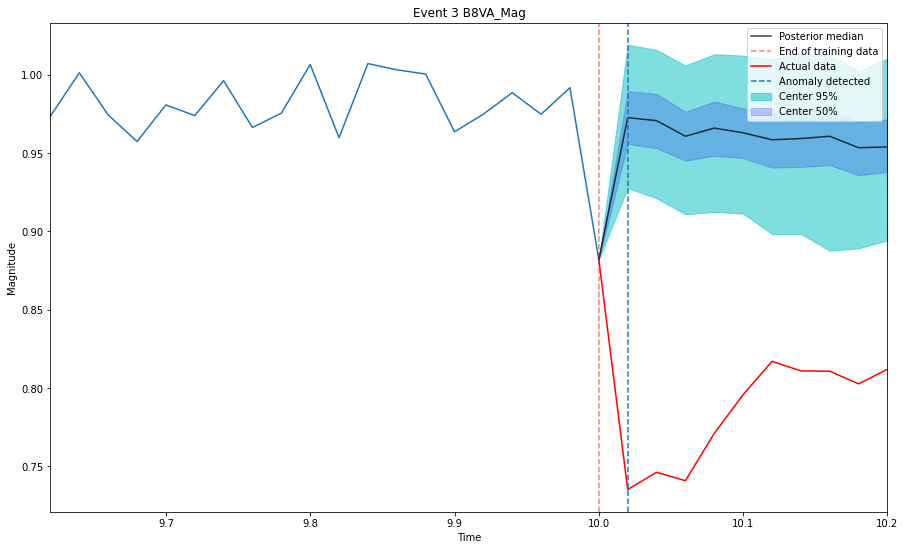

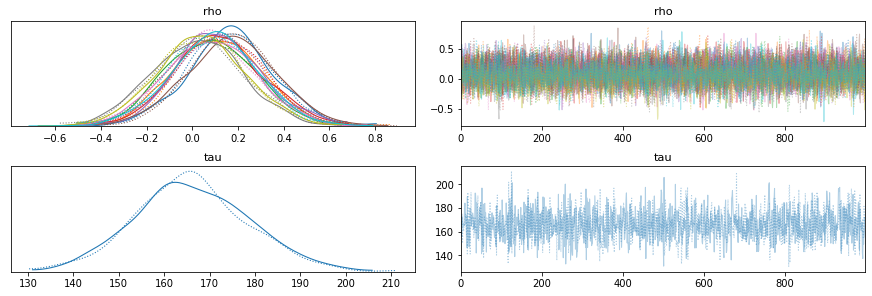

           mean      sd   hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
rho[0]    0.166   0.184   -0.202    0.497  ...  1354.0    2402.0    1398.0    1.0
rho[1]    0.118   0.192   -0.249    0.458  ...  1233.0    2326.0    1543.0    1.0
rho[2]    0.078   0.196   -0.272    0.459  ...   862.0    2335.0     982.0    1.0
rho[3]    0.116   0.191   -0.214    0.504  ...  1288.0    2527.0    1578.0    1.0
rho[4]    0.118   0.190   -0.251    0.477  ...  1174.0    2138.0    1117.0    1.0
rho[5]    0.175   0.191   -0.185    0.530  ...  1462.0    2349.0    1354.0    1.0
rho[6]    0.078   0.193   -0.277    0.456  ...  1129.0    2386.0    1357.0    1.0
rho[7]    0.023   0.197   -0.320    0.413  ...   915.0    2060.0    1290.0    1.0
rho[8]    0.038   0.193   -0.324    0.407  ...   805.0    2264.0    1204.0    1.0
rho[9]    0.091   0.192   -0.281    0.433  ...   979.0    2299.0    1395.0    1.0
tau     166.135  12.436  141.703  188.667  ...  1900.0    1998.0    1338.0    1.0

[11 rows x 11 c

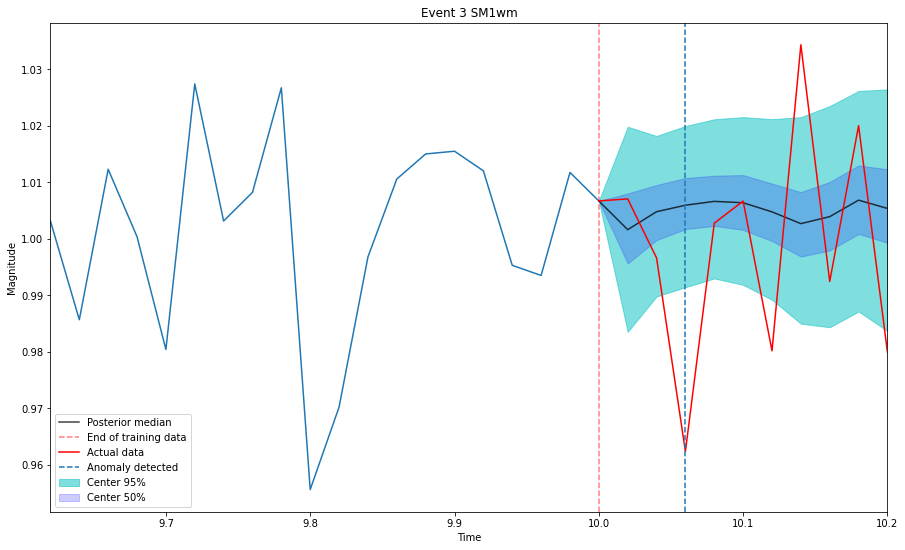

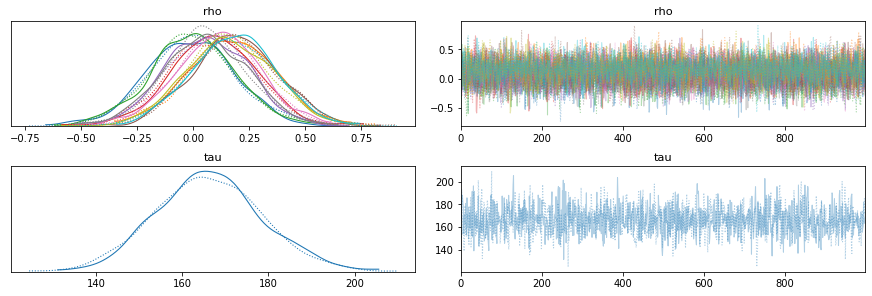

           mean      sd   hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
rho[0]   -0.008   0.196   -0.375    0.362  ...   889.0    1938.0    1209.0    1.0
rho[1]    0.171   0.195   -0.227    0.514  ...  1047.0    1606.0    1234.0    1.0
rho[2]   -0.003   0.193   -0.377    0.355  ...  1013.0    2410.0    1551.0    1.0
rho[3]    0.088   0.193   -0.294    0.422  ...   895.0    1804.0    1232.0    1.0
rho[4]    0.061   0.187   -0.300    0.396  ...  1185.0    2370.0    1555.0    1.0
rho[5]    0.187   0.191   -0.150    0.544  ...  1227.0    1839.0    1201.0    1.0
rho[6]    0.109   0.186   -0.230    0.473  ...  1252.0    2721.0    1590.0    1.0
rho[7]    0.058   0.188   -0.267    0.451  ...   977.0    1601.0    1455.0    1.0
rho[8]    0.157   0.192   -0.225    0.491  ...  1120.0    2185.0    1156.0    1.0
rho[9]    0.179   0.191   -0.178    0.533  ...  1488.0    1906.0    1579.0    1.0
tau     166.214  12.222  142.759  188.813  ...  1811.0    1818.0    1437.0    1.0

[11 rows x 11 c

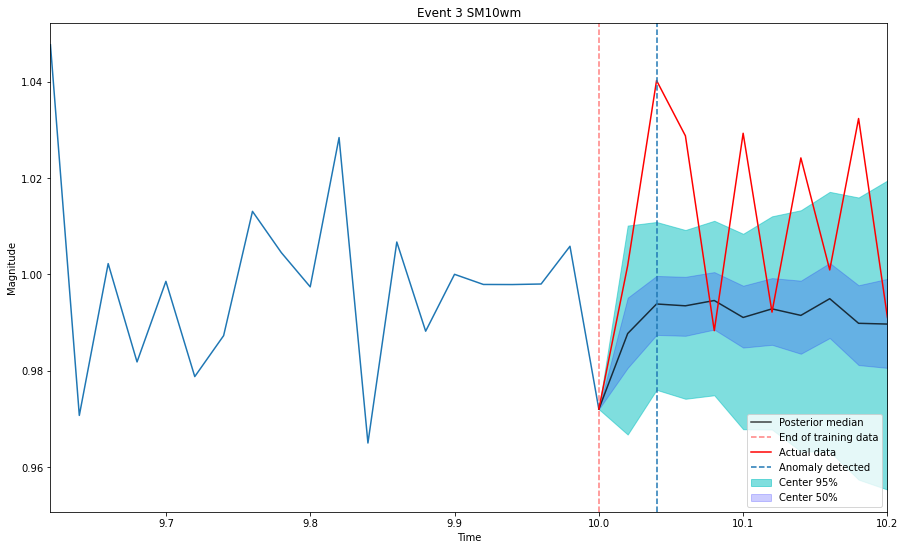

In [0]:
with open('event3traces.pickle', 'rb') as file:
        event3TracePickle = pickle.load(file)
for column in event3.columns:
  trace = event3TracePickle[column]
  full_data = event3[column]
  normal_data = full_data[train_start:anom_start]
  ratio = 1/50
  plotPrediction(trace, normal_data, full_data, anom_start, 'Event 3 {}'.format(column), ratio=ratio)

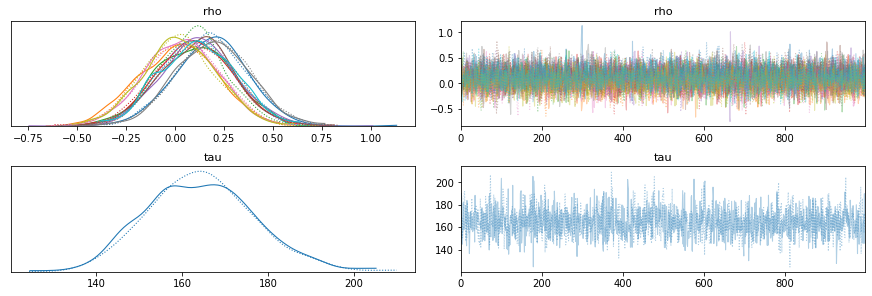

           mean      sd   hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
rho[0]    0.189   0.189   -0.175    0.519  ...  1076.0    1643.0    1256.0   1.00
rho[1]    0.018   0.195   -0.337    0.384  ...   798.0    2089.0    1272.0   1.00
rho[2]    0.093   0.187   -0.268    0.437  ...   852.0    2037.0     991.0   1.01
rho[3]    0.096   0.195   -0.280    0.434  ...   955.0    2297.0    1125.0   1.00
rho[4]    0.118   0.187   -0.222    0.458  ...   917.0    2158.0    1360.0   1.00
rho[5]    0.118   0.193   -0.271    0.448  ...  1162.0    2253.0    1129.0   1.00
rho[6]    0.034   0.190   -0.347    0.364  ...   770.0    2018.0    1252.0   1.00
rho[7]    0.194   0.191   -0.160    0.550  ...  1620.0    2081.0    1375.0   1.00
rho[8]    0.026   0.186   -0.332    0.361  ...  1095.0    2130.0    1455.0   1.00
rho[9]    0.114   0.188   -0.189    0.503  ...  1368.0    1960.0    1293.0   1.00
tau     164.481  12.411  141.237  187.502  ...  2029.0    2123.0    1417.0   1.00

[11 rows x 11 c

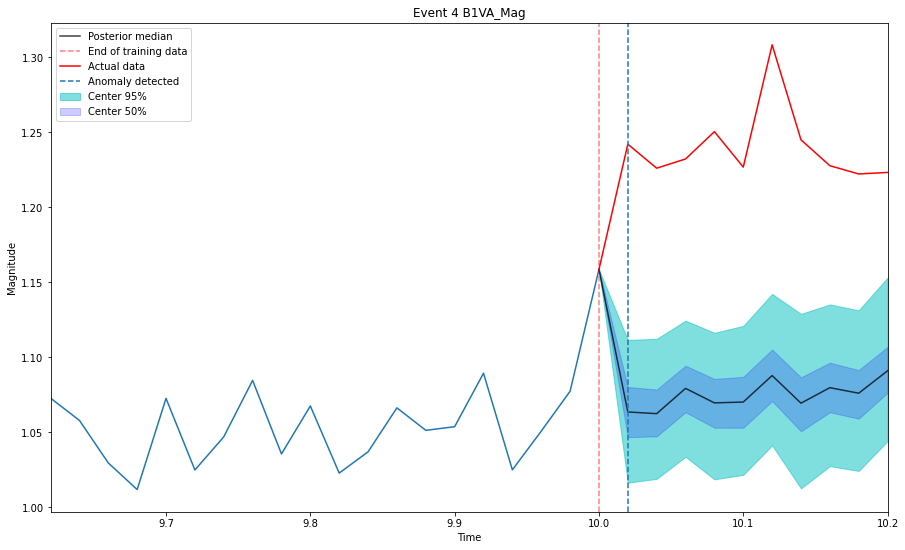

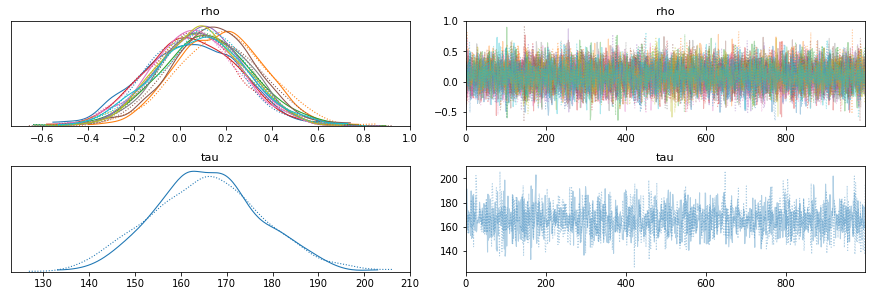

           mean      sd   hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
rho[0]    0.051   0.202   -0.321    0.421  ...   838.0    2483.0    1197.0   1.00
rho[1]    0.180   0.193   -0.159    0.564  ...  1575.0    2409.0    1503.0   1.00
rho[2]    0.112   0.202   -0.256    0.502  ...   960.0    2312.0    1103.0   1.00
rho[3]    0.057   0.199   -0.328    0.412  ...   985.0    2289.0    1328.0   1.00
rho[4]    0.097   0.191   -0.258    0.455  ...  1021.0    2363.0    1429.0   1.00
rho[5]    0.146   0.194   -0.209    0.502  ...   888.0    2123.0     934.0   1.00
rho[6]    0.063   0.196   -0.342    0.409  ...   907.0    2192.0    1251.0   1.00
rho[7]    0.108   0.188   -0.225    0.474  ...  1357.0    2422.0    1500.0   1.00
rho[8]    0.090   0.192   -0.265    0.454  ...   900.0    2528.0    1294.0   1.00
rho[9]    0.096   0.202   -0.308    0.445  ...   810.0    2276.0    1064.0   1.01
tau     165.885  11.846  144.099  188.136  ...  2345.0    2372.0    1435.0   1.00

[11 rows x 11 c

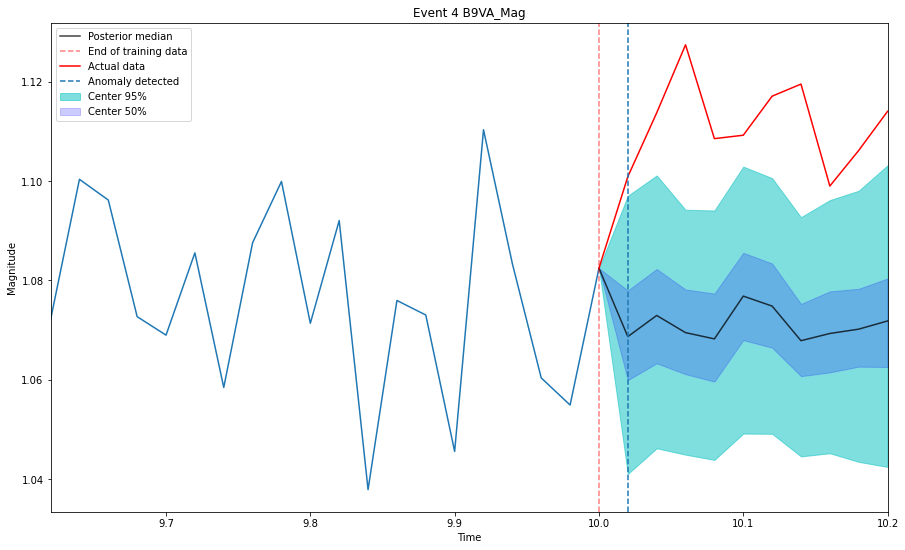

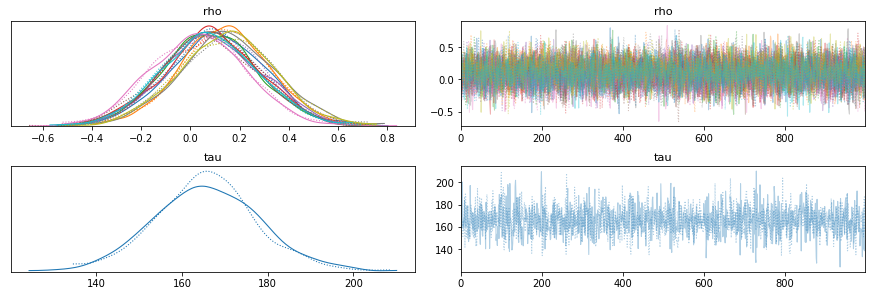

           mean      sd   hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
rho[0]    0.106   0.194   -0.259    0.453  ...  1017.0    1735.0    1223.0    1.0
rho[1]    0.139   0.184   -0.203    0.500  ...  1362.0    2060.0    1585.0    1.0
rho[2]    0.085   0.192   -0.257    0.459  ...   999.0    1974.0    1442.0    1.0
rho[3]    0.091   0.196   -0.295    0.435  ...  1030.0    2208.0    1384.0    1.0
rho[4]    0.096   0.192   -0.240    0.483  ...  1210.0    2097.0    1257.0    1.0
rho[5]    0.073   0.196   -0.301    0.435  ...   824.0    1832.0    1247.0    1.0
rho[6]    0.036   0.195   -0.306    0.406  ...   754.0    1930.0    1314.0    1.0
rho[7]    0.149   0.199   -0.219    0.527  ...  1112.0    1885.0    1139.0    1.0
rho[8]    0.148   0.195   -0.245    0.494  ...  1312.0    1551.0    1459.0    1.0
rho[9]    0.077   0.193   -0.289    0.428  ...  1020.0    1972.0    1357.0    1.0
tau     165.859  12.214  143.398  190.049  ...  1940.0    1944.0    1297.0    1.0

[11 rows x 11 c

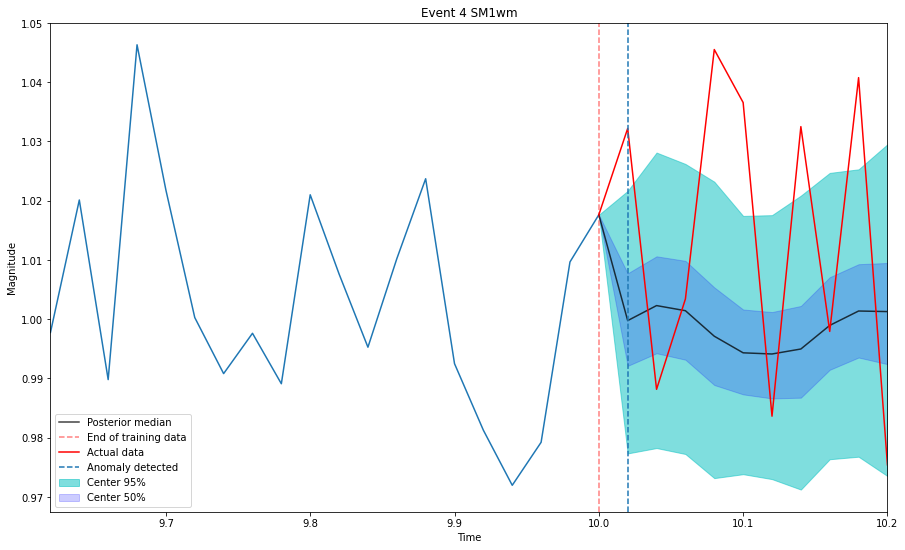

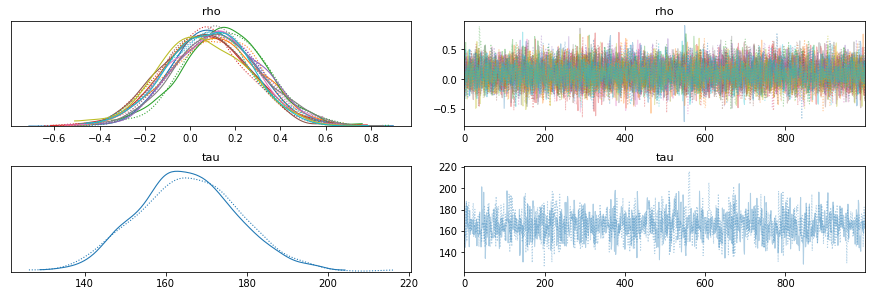

           mean      sd   hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
rho[0]    0.111   0.181   -0.210    0.443  ...   928.0    1888.0    1301.0    1.0
rho[1]    0.106   0.200   -0.261    0.476  ...  1113.0    2034.0    1434.0    1.0
rho[2]    0.154   0.186   -0.209    0.503  ...  1020.0    1852.0    1185.0    1.0
rho[3]    0.067   0.194   -0.300    0.419  ...   837.0    2459.0    1319.0    1.0
rho[4]    0.127   0.188   -0.213    0.471  ...  1426.0    2281.0    1378.0    1.0
rho[5]    0.067   0.190   -0.292    0.415  ...  1049.0    1934.0    1372.0    1.0
rho[6]    0.099   0.192   -0.271    0.446  ...  1348.0    2362.0    1552.0    1.0
rho[7]    0.120   0.191   -0.248    0.466  ...  1135.0    1702.0    1210.0    1.0
rho[8]    0.067   0.193   -0.270    0.443  ...  1131.0    2099.0    1510.0    1.0
rho[9]    0.083   0.187   -0.260    0.454  ...  1050.0    1980.0    1193.0    1.0
tau     165.554  12.560  142.006  188.671  ...  1854.0    1929.0    1293.0    1.0

[11 rows x 11 c

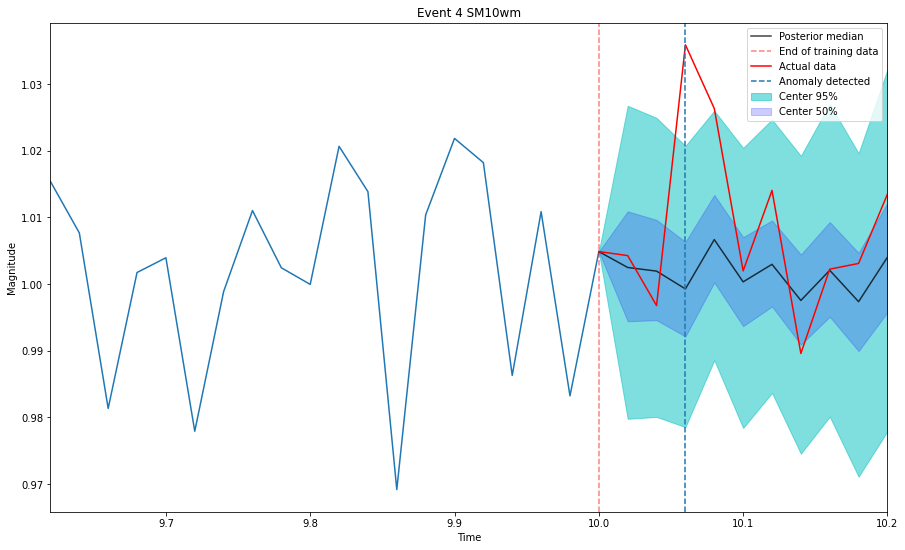

In [0]:
with open('event4traces.pickle', 'rb') as file:
        event4TracePickle = pickle.load(file)
for column in event4.columns:
  trace = event4TracePickle[column]
  full_data = event4[column]
  normal_data = full_data[train_start:anom_start]
  ratio = 1/50
  plotPrediction(trace, normal_data, full_data, anom_start, 'Event 4 {}'.format(column), ratio=ratio)